https://colab.research.google.com/gist/Lihi-Gur-Arie/7cac63dbffde55449d2444e402d87bfc/image_search_engine_by_lihi_gur_arie.ipynb#scrollTo=2aZ6hBjJDWAW

# <font color=40534C size="6.5">**Building an Image Similarity Search Engine with FAISS & CLIP**</font>

<font color=40534C>This notebook is part of the **"Building an Image Similarity Search Engine with FAISS and CLIP"**  tutorial by  **Dr. Lihi Gur Arie**.
For the full tutorial please visit [here](https://medium.com/@lihigurarie/2211126d08fa?source=friends_link&sk=4d3ed082bd53b0e2ada2f660bd0da5ad)<font>

<font color=40534C>**Install & import Requirements**</font>

In [8]:
!pip install sentence-transformers
# !pip install faiss-gpu 
!pip install faiss-cpu
!pip install matplotlib

import os
from glob import glob
from PIL import Image
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import random

<font color=40534C size="5.5">**Step 1 - Explore the Data**</font>

<font color=40534C>**Get the dataset and extract the zip file:**</font>

In [12]:
# !wget -O data.zip https://drive.usercontent.google.com/download?id=1q3dpti5aX4LdD3Mq7bZ4rjTeZbQEljiy&export=download&authuser=0
!unzip "data.zip"

Archive:  data.zip
   creating: image_dataset
  inflating: image_dataset/pexels-polina-tankilevitch-3735147.jpg  
  inflating: image_dataset/pexels-steve-1047540.jpg  
  inflating: image_dataset/pexels-nubikini-385997.jpg  
  inflating: image_dataset/pexels-monkeytactics-752035.jpg  
  inflating: image_dataset/pexels-neosiam-681118.jpg  
  inflating: image_dataset/pexels-pixabay-45851.jpg  
  inflating: image_dataset/pexels-dziana-hasanbekava-5480749.jpg  
  inflating: image_dataset/pexels-introspectivedsgn-5158160.jpg  
  inflating: image_dataset/pexels-pixabay-209154.jpg  
  inflating: image_dataset/pexels-shvetsa-3846048.jpg  
  inflating: image_dataset/pexels-belle-co-99483-672916.jpg  
  inflating: image_dataset/pexels-junnoet-235226.jpg  
  inflating: image_dataset/pexels-cottonbro-5077047.jpg  
  inflating: image_dataset/pexels-leomara-paiva-103844600-9483502.jpg  
  inflating: image_dataset/pexels-valeriya-1251198.jpg  
  inflating: image_dataset/pexels-todd-trapani-488382-1382

<font color=40534C>**Display random images from the dataset:**</font>

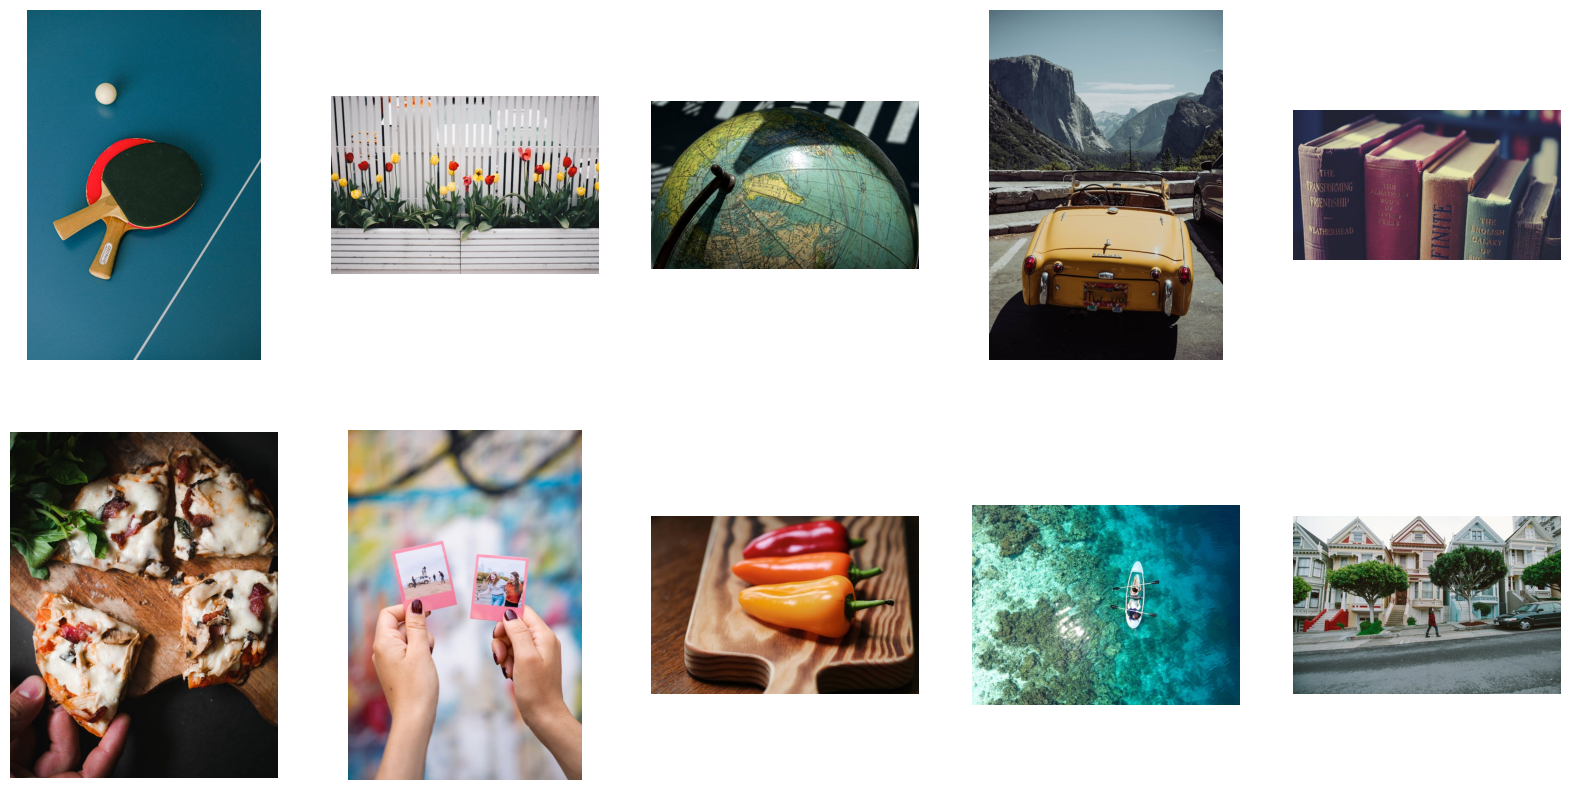

In [14]:
image_folder = './image_dataset'

# Get a list of all image files in the folder
image_files = glob(os.path.join(image_folder, '*.jpg'))

# Randomly select 10 image files
random.seed(42)
selected_images = random.sample(image_files, 10)

# Display the selected images
plt.figure(figsize=(20, 10))
for i, image_path in enumerate(selected_images):
    img = Image.open(image_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

<font color=40534C size="5.5">**Step 2 - Generate CLIP embeddings**</font>

In [ ]:
def generate_clip_embeddings(images_path, model):

    image_paths = glob(os.path.join(images_path, '**/*.jpg'), recursive=True)

    embeddings = []
    for img_path in image_paths:
        image = Image.open(img_path)
        embedding = model.encode(image)
        embeddings.append(embedding)

    return embeddings, image_paths



IMAGES_PATH = './image_dataset'
model = SentenceTransformer('clip-ViT-B-32')
embeddings, image_paths = generate_clip_embeddings(IMAGES_PATH, model)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [26]:
from transformers import AutoImageProcessor
processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [27]:
processor

CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

<font color=40534C size="5.5">**Step 3 - Generate FAISS Index with Image Embeddings**</font>

<font color=40534C>**Create and Save FAISS Index:**</font>



In [25]:
model

SentenceTransformer(
  (0): CLIPModel()
)

In [24]:
len(embeddings), len(embeddings[0])

(52, 512)

In [17]:
def create_faiss_index(embeddings, image_paths, output_path):

    dimension = len(embeddings[0])
    index = faiss.IndexFlatIP(dimension)
    index = faiss.IndexIDMap(index)

    vectors = np.array(embeddings).astype(np.float32)

    # Add vectors to the index with IDs
    index.add_with_ids(vectors, np.array(range(len(embeddings))))

    # Save the index
    faiss.write_index(index, output_path)
    print(f"Index created and saved to {output_path}")

    # Save image paths
    with open(output_path + '.paths', 'w') as f:
        for img_path in image_paths:
            f.write(img_path + '\n')

    return index


OUTPUT_INDEX_PATH = "./vector.index"
index = create_faiss_index(embeddings, image_paths, OUTPUT_INDEX_PATH)

Index created and saved to ./vector.index


<font color=40534C>**Load FAISS index:**</font>



In [18]:
def load_faiss_index(index_path):
    index = faiss.read_index(index_path)
    with open(index_path + '.paths', 'r') as f:
        image_paths = [line.strip() for line in f]
    print(f"Index loaded from {index_path}")
    return index, image_paths

index, image_paths = load_faiss_index(OUTPUT_INDEX_PATH)

Index loaded from ./vector.index


<font color=40534C size="5.5">**Step 4 - Retrieve Images by Text Query or Referance Image**</font>

<font color=40534C>**A function to retrive images with Text or Image query:**</font>



In [19]:
def retrieve_similar_images(query, model, index, image_paths, top_k=3):

    if query.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        query = Image.open(query)

    query_features = model.encode(query)
    query_features = query_features.astype(np.float32).reshape(1, -1)

    distances, indices = index.search(query_features, top_k)

    retrieved_images = [image_paths[int(idx)] for idx in indices[0]]

    return query, retrieved_images

<font color=40534C>**An helper function to display results:**</font>



In [20]:
def visualize_results(query, retrieved_images):
    plt.figure(figsize=(12, 5))

    # If image query
    if isinstance(query, Image.Image):
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.imshow(query)
        plt.title("Query Image")
        plt.axis('off')
        start_idx = 2

    # If text query
    else:
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.text(0.5, 0.5, f"Query:\n\n '{query}'", fontsize=16, ha='center', va='center')
        plt.axis('off')
        start_idx = 2

    # Display images
    for i, img_path in enumerate(retrieved_images):

        plt.subplot(1, len(retrieved_images) + 1, i + start_idx)
        plt.imshow(Image.open(img_path))
        plt.title(f"Match {i + 1}")
        plt.axis('off')

    plt.show()

<font color=40534C>**Search with a Text Query:**</font>



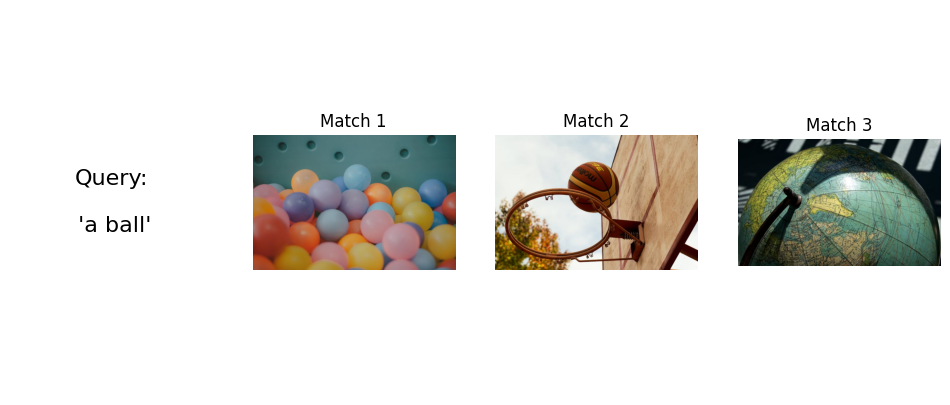

In [21]:
query = 'a ball'
query, retrieved_images = retrieve_similar_images(query, model, index, image_paths, top_k=3)
visualize_results(query, retrieved_images)

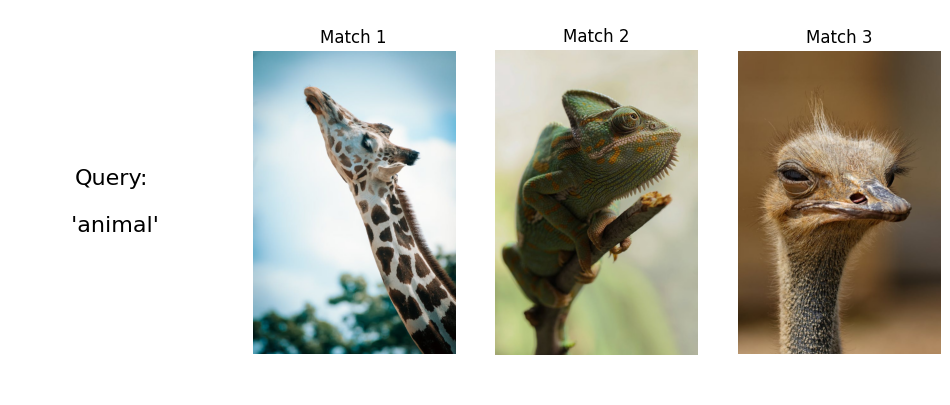

In [22]:
# Example with text query
query = 'animal'
query, retrieved_images = retrieve_similar_images(query, model, index, image_paths, top_k=3)
visualize_results(query, retrieved_images)

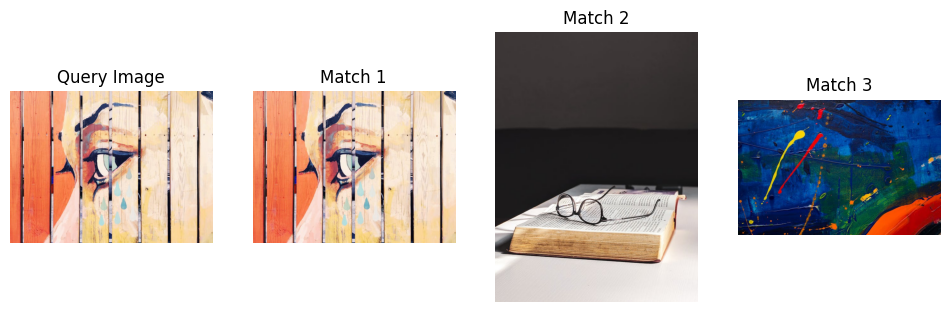

In [28]:
query = './image_dataset/pexels-w-w-299285-889839.jpg'
query, retrieved_images = retrieve_similar_images(query, model, index, image_paths, top_k=3)
visualize_results(query, retrieved_images)

# <font color=40534C size="6.5">**The End!**</font>
<font color=40534C>For more content from the author, please visit  [Here](https://medium.com/@lihigurarie)</font>